Let's run a Monte Carlo with a new transient metric that computes some agregate of transient properties

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

In [2]:
class TransientMonteMetric(metrics.BaseMetric):
    """
    Generate a population of transient objects and see what fraction are detected
    """
    
    def __init__(self, metricName='TransientMonteMetric', mjdCol='expMJD', m5Col='fiveSigmaDepth',
                 filterCol='filter', duration=1., **kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        super(TransientMonteMetric, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol],
                                                  units='Fraction Detected',
                                                  metricName=metricName, **kwargs)
        # Properties of the transient object
        self.duration = duration
        
    def lightCurve(self, t, t0, m_r_0):
        """
        Let's say this is a simple object that pops up and linearly decays for 10 days
        
        t0:  mjd of initial detection
        m_r_0: initial r-band brightness
        times: array of mjd
        """
        
        good = np.where( (t >= t0) & (t <= t0+self.duration))
        mags = np.zeros(t.size, dtype=float)
        mags.fill(300.) #  Set to very faint by default
        mags[good] = m_r_0
        return mags
        
    def run(self,  dataSlice, slicePoint=None):
        
        objRate = 0.7 # how many go off per day
        # Define the magnitude distribution
        timeSpan = dataSlice[self.mjdCol].max() - dataSlice[self.mjdCol].min()
        # decide how many objects we want to generate
        nObj = np.random.poisson(timeSpan*objRate)
        t0s = np.random.rand(nObj)*timeSpan
        m0s = np.random.rand(nObj)*2.+20.
        t = dataSlice[self.mjdCol] - dataSlice[self.mjdCol].min()
        detected = np.zeros(t0s.size)
        # Loop though each generated transient and decide if it was detected
        for i,t0 in enumerate(t0s):
            lc = self.lightCurve(t, t0, m0s[i])
            detectTest = dataSlice[self.m5Col] - lc
            if detectTest.max() > 0:
               detected[i] += 1
        # Return the fraction of transients detected
        return float(np.sum(detected))/float(nObj)
    

In [7]:
runName = 'minion_1016'
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'TransientsMonte'
resultsDb = db.ResultsDb(outDir=outDir)

In [8]:
metric = TransientMonteMetric()
sql = 'night < 365'
slicer = slicers.HealpixSlicer(nside=8)
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName)
bundleList = [bundle]
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)

Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes


Querying database with constraint night < 365
Found 262451 visits
Running:  ['minion_1016_TransientMonteMetric_night_lt_365_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with night < 365 constraint now.
monopole: 0.139654  dipole: lon: -27.0649, lat: -38.948, amp: 0.105861
Plotting complete.


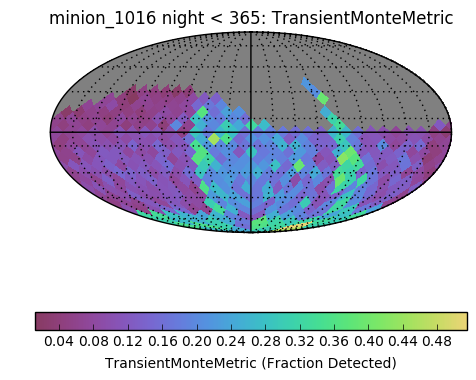

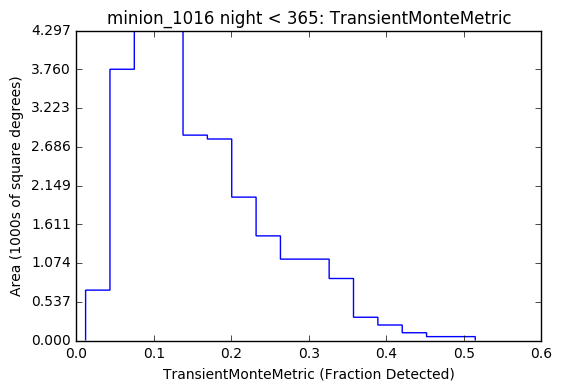

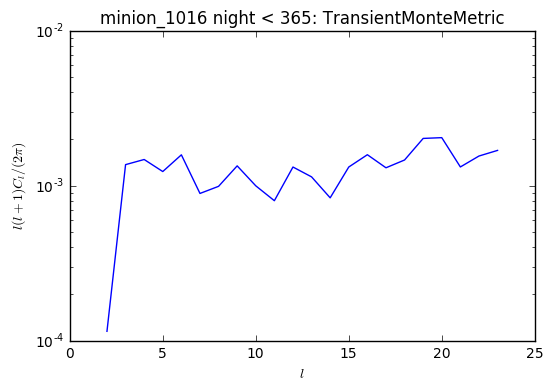

In [9]:
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)